In [1]:
### Library
import numpy as np
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path
from itertools import product

from tqdm import tqdm
from tqdm.auto import trange

import warnings
import pickle
import json
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
from torchmetrics import regression
from collections import defaultdict

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoDiagonalNormal

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

from pymoo.core.variable import Choice
import shap

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'> Using device: {device}')

def set_seed(seed=12):
    np.random.seed(seed)
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

pyro.clear_param_store()
plt.style.use('ggplot')
set_seed(12)

> Using device: cuda:0


In [2]:
parameter_gama = 4.0
parameter_gama_rate = 0.5
parameter_prior_scale_input = 7.0
parameter_prior_scale_hidden = 8.0
parameter_prior_scale_output = 4.0

class BNN(PyroModule):
    def __init__(self, in_dim=5, out_dim=75, hid_dim=128, device='cuda'):
        super(BNN, self).__init__()
        self.activation = nn.LeakyReLU(0.1)
        self.dropout = PyroModule[nn.Dropout](0.05)
        self.out_dim = out_dim  
        self.device = device

        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim)
    
    # 5 layers for 5 scenarios
        self.layer4_sc1 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc2 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc3 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc4 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc5 = PyroModule[nn.Linear](hid_dim, out_dim)

        # Prior scales
        self.prior_scale_input = parameter_prior_scale_input
        self.prior_scale_hidden = parameter_prior_scale_hidden
        self.prior_scale_output = parameter_prior_scale_output

        # Set priors for each layer
        self.layer1.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, in_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, in_dim, device=device)).to_event(2)
        )
        self.layer1.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer2.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer2.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer3.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer3.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        # Priors for 5 scenarios output layers
        for sc in range(1, 6):
            layer = getattr(self, f"layer4_sc{sc}")
            layer.weight = PyroSample(
                dist.Normal(torch.zeros(out_dim, hid_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, hid_dim, device=device)).to_event(2)
            )
            layer.bias = PyroSample(
                dist.Normal(torch.zeros(out_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, device=device)).to_event(1)
            )

    def forward(self, x, y=None):
        x = x.to(self.device).float()
        batch_size = x.shape[0]
        if len(x.shape) > 2:
            x = x.reshape(batch_size, -1)

        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        residual = x
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        x = self.activation(self.layer3(x))
        x = x + residual

        # Calculate mu for each scenario
        mu_sc1 = self.layer4_sc1(x)
        mu_sc2 = self.layer4_sc2(x)
        mu_sc3 = self.layer4_sc3(x)
        mu_sc4 = self.layer4_sc4(x)
        mu_sc5 = self.layer4_sc5(x)
        mu = torch.stack([mu_sc1, mu_sc2, mu_sc3, mu_sc4, mu_sc5], dim=1)  # [batch_size, 5, 76]

        # Sample df and sigma
        df = pyro.sample("df", 
                        dist.Gamma(concentration=torch.tensor(parameter_gama, device=self.device), 
                                rate=torch.tensor(parameter_gama_rate, device=self.device)))
        sigma = pyro.sample("sigma", 
                        dist.HalfCauchy(torch.ones(5, self.out_dim, device=self.device)).to_event(2))

        # Chose likelihood for each scenario
        with pyro.plate("data", batch_size):
            for i in range(5):
                pyro.sample(f"obs_sc{i}", 
                        dist.StudentT(df=df, loc=mu[:, i, :], scale=sigma[i, :]).to_event(1), 
                        obs=y[:, i, :] if y is not None else None)

        return mu
    
    def hyperparameter_init(self, loss_func, guide, optimizer):
        self.loss_func = loss_func
        self.guide = guide
        self.optimizer = optimizer
        self.svi = SVI(self, self.guide, self.optimizer, loss=self.loss_func)
        self.history = {}
        self.save_path = None
        return

    def epoch_train(self, data_input, data_output):
        epoch_loss = self.svi.step(data_input, data_output) / data_input.shape[0]
        return epoch_loss

    def stop_condition(self, tol, patience, num_epochs):
        epoch = len(self.history['train_loss']) - 1
        self.max_epoch = epoch
        if epoch < 1:
            self.best_epoch = 0
            return False

        if self.history['train_loss'][epoch] <= self.history['train_loss'][self.best_epoch]:
            self.best_epoch = epoch
            self.best_guide = self.guide
            self.best_param_store = pyro.get_param_store()
            self.best_history = {key: value[epoch] for key, value in self.history.items()}

        if self.history['train_loss'][epoch] <= tol:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching the tolerance of {tol:.3f}')
            return True

        if epoch + 1 >= patience and min(self.history['train_loss'][-patience:]) > self.history['train_loss'][self.best_epoch]:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching maximum patience of {patience}')
            return True

        if epoch + 1 == num_epochs:
            print(f'> Model stopping at epoch {epoch+1:03} due to reaching maximum epochs {num_epochs}')
            return True
        return False

    def plot_loss(self):
        if epoch < 1:
            plt.ion()  # Turn on interactive mode
            plt.rcParams['text.usetex'] = True
            self.fig, self.ax = plt.subplots(figsize=(8, 6))
            self.train_loss_line, = self.ax.plot([], [], label="Train Loss", color='b',
                                                linestyle='-', linewidth=2)
            self.fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)
            self.ax.set_xlabel('Epochs', fontsize=12)
            self.ax.set_ylabel('Loss', fontsize=12)
            self.ax.tick_params(axis='x', labelsize=10)
            self.ax.tick_params(axis='y', labelsize=10)
            self.ax.set_yscale('log')
            self.ax.legend(loc='upper right', fontsize=10)
            plt.tight_layout()
            plt.grid(True)
            # self.fig.canvas.manager.window.activateWindow()
            # self.fig.canvas.manager.window.raise_()
        else:
            self.train_loss_line.set_data(range(epoch+1), self.history["train_loss"])

            self.ax.set_xlim(0, epoch + 1)
            self.ax.set_ylim(min(self.history["train_loss"])*0.8, max(self.history["train_loss"])*1.2)
            # self.ax.relim()
            # self.ax.autoscale_view()

            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
        return

In [3]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [4]:
### Get data
data_df = pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'full_data_sampling.csv'), index_col=0, header=0)
data_df = data_df.drop_duplicates()

input_variables = ['$x_{1}$', '$x_{2}$', '$x_{3}$', '$x_{5}$', '$x_{8}$']
input_variables_names = ["$x_{1}$: External wall thickness (mm)", 
                         "$x_{2}$: Internal wall thickness (mm)", 
                         "$x_{3}$: Thermal conductivity of Wall bricks (W/mK)", 
                         "$x_{5}$: Thermal resistance of Roof infill-blocks (m$^{2}$K/W)",
                         "$x_{8}$: Indoor air temperature (°C)", 
                         "$z$: Climate change scenario"]
output_variables = [f'$y^{{{year}}}$' for year in range(2026, 2101)]

lst_input_features = []
lst_output_features = []

grouped = data_df.groupby('idx')
for design, group in tqdm(grouped):
    input_features = group[input_variables].iloc[0].values.tolist()
    output_features = group[output_variables].values.tolist()
    lst_input_features.append(input_features)
    lst_output_features.append(output_features)

# Convert to numpy arrays
lst_input_features = np.array(lst_input_features)
lst_output_features = np.array(lst_output_features)

# Scale input data
scaler_input = StandardScaler().fit(lst_input_features)
input_array = scaler_input.transform(lst_input_features)

# Scale output data
scalers_output = [StandardScaler().fit([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])]
output_array = np.stack([scalers_output[j].transform([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])], axis=1)

# Convert to tensors
data_input_tensor = torch.tensor(input_array, dtype=torch.float32).to(device)
data_output_tensor = torch.tensor(output_array, dtype=torch.float32).to(device)
torch.cuda.empty_cache()
# data_tensor = TensorDataset(data_input_tensor, data_output_tensor)

# Climate data
mean_climate_temp = [pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'climate_data_sampling_SSP1-1.9.csv'), index_col=0, header=0).mean(),
                     pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'climate_data_sampling_SSP1-2.6.csv'), index_col=0, header=0).mean(),
                     pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'climate_data_sampling_SSP2-4.5.csv'), index_col=0, header=0).mean(),
                     pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'climate_data_sampling_SSP3-7.0.csv'), index_col=0, header=0).mean(),
                     pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'climate_data_sampling_SSP5-8.5.csv'), index_col=0, header=0).mean()]
for i in range(len(mean_climate_temp)):
    mean_climate_temp[i].index = mean_climate_temp[i].index.astype(int)

100%|██████████| 199200/199200 [00:58<00:00, 3413.15it/s]
C:\Users\tqkim\AppData\Local\Temp\ipykernel_4212\3963919900.py:37: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  data_input_tensor = torch.tensor(input_array, dtype=torch.float32).to(device)


In [5]:
### Load saved model
load_path = os.path.join(script_dir, 'Results', 'BNN_Model', '250326_085053', '091909')

pyro.clear_param_store()
model = torch.load(os.path.join(load_path, 'BNN_model.pt'), map_location=device, weights_only=False)
with open(os.path.join(load_path, 'Best_BNN_guide.pkl'), 'rb') as f:
    guide = pickle.load(f)
    
# Load the params file with weights_only=False
with open(os.path.join(load_path, 'Best_BNN_params.pt'), 'rb') as input_file:
    state = torch.load(input_file, map_location=device, weights_only=False)
    
# Set the state in the param store
pyro.get_param_store().set_state(state)

In [6]:
### Evaluate the model
print('----- Model evaluation -----')
torch.cuda.empty_cache()
model.eval()
guide.requires_grad_(False)

train_best_loss = model.history["train_loss"][model.best_epoch]
recal_best_loss = Trace_ELBO().loss(model, guide, data_input_tensor, data_output_tensor) / data_input_tensor.shape[0]

print(f'> Saved best loss: {train_best_loss:.3f}')
print(f'> Recalculated best loss: {recal_best_loss:.3f}')

predictive = Predictive(model, guide=guide, num_samples=200, return_sites=("_RETURN", "obs_sc0", "obs_sc1", "obs_sc2", "obs_sc3", "obs_sc4"))

mean_obs_output = data_output_tensor.reshape(-1, 200, 5, 75).permute(1, 0, 2, 3).cpu().numpy().mean(axis=0)
data_unique_tensor = torch.from_numpy(pd.DataFrame(data_input_tensor.cpu().numpy()).drop_duplicates().values).float().to(device)
mean_pred_output = predictive(data_unique_tensor)['_RETURN'].cpu().numpy().mean(axis=0)
# mean_pred_output = torch.stack([predictive(data_unique_tensor)[f'obs_sc{i}'] for i in range(5)], dim=2).cpu().numpy().mean(axis=0)

mean_obs_output = np.array([scalers_output[i].inverse_transform(mean_obs_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)
mean_pred_output = np.array([scalers_output[i].inverse_transform(mean_pred_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)

RMSE = np.sqrt(mean_squared_error(mean_obs_output.flatten(), mean_pred_output.flatten()))
MAPE = mean_absolute_percentage_error(mean_obs_output.flatten(), mean_pred_output.flatten())*100.

print(f'> Overall RMSE: {RMSE:.3f}')
print(f'> Overall MAPE: {MAPE:.3f}%')

RMSE_list = [np.sqrt(mean_squared_error(mean_obs_output[i,:], mean_pred_output[i,:]))
             for i in range(mean_obs_output.shape[0])]
MAPE_list = [mean_absolute_percentage_error(mean_obs_output[i,:], mean_pred_output[i,:])*100
             for i in range(mean_obs_output.shape[0])]

print(f'> Per-sample RMSE: {np.min(RMSE_list):.3f} (Min), {np.mean(RMSE_list):.3f} (Mean), {np.max(RMSE_list):.3f} (Max)')
print(f'> Per-sample MAPE: {np.min(MAPE_list):.3f}% (Min), {np.mean(MAPE_list):.3f}% (Mean), {np.max(MAPE_list):.3f}% (Max)')


----- Model evaluation -----
> Saved best loss: -60.083
> Recalculated best loss: -16.450
> Overall RMSE: 0.591
> Overall MAPE: 1.767%
> Per-sample RMSE: 0.061 (Min), 0.503 (Mean), 1.463 (Max)
> Per-sample MAPE: 0.288% (Min), 1.767% (Mean), 3.851% (Max)


In [10]:
### Define objective cost functions
def find_pred_output_tensor(random_samples, scaler_input, scalers_output, predictive):
    random_sample_input_tensor = scaler_input.transform(random_samples)
    random_sample_input_tensor = torch.from_numpy(random_sample_input_tensor).float().to(device)

    pred_output = torch.stack([predictive(random_sample_input_tensor)[f'obs_sc{i}'] for i in range(5)], dim=2)

    pred_output_tensor = {
        'mean': torch.mean(pred_output, 0),
        'low_5': pred_output.kthvalue(int(len(pred_output) * 0.05), dim=0)[0],
        'high_95': pred_output.kthvalue(int(len(pred_output) * 0.95), dim=0)[0],
    }

    for key, value in pred_output_tensor.items():
        pred_output_tensor[key] = np.stack([scalers_output[i].inverse_transform(value[:,i,:].cpu().numpy()) for i in range(value.shape[1])], axis=1).transpose(2,1,0)
        pred_output_tensor[key] = [pd.DataFrame(pred_output_tensor[key][:,i,:], index=range(2026,2101)) for i in range(value.shape[1])]

    pred_output_tensor['data'] = np.stack([scalers_output[i].inverse_transform(pred_output[:,:,i,:].cpu().numpy().transpose(1,0,2).reshape(-1,75)) for i in range(pred_output.shape[2])], axis=1)
    pred_output_tensor['data'] = [pd.DataFrame(pred_output_tensor['data'][:,i,:].transpose(),
                                            index=range(2026,2101), 
                                            columns=[f'design_{j}_sample_{k}' for j in range(pred_output.shape[1]) for k in range(pred_output.shape[0])]
                                            ) for i in range(pred_output_tensor['data'].shape[1])]

    pred_output_tensor['std'] = np.stack([torch.std(pred_output, 0)[:,i,:].cpu().numpy() * scalers_output[i].scale_ for i in range(pred_output.shape[2])], axis=1).transpose(2,1,0)
    pred_output_tensor['std'] = [pd.DataFrame(pred_output_tensor['std'][:,i,:], index=range(2026,2101)) for i in range(pred_output.shape[2])]

    return pred_output_tensor

def find_pred_cost_func_tensor(pred_output_tensor, cost_func='y'):
    pred_func_tensor = dict.fromkeys(pred_output_tensor)
    if cost_func == 'y':
        pred_func_tensor = pred_output_tensor
    else:
        rho = 0.99
        std_devs = [pred_output_tensor['std'][i].to_numpy() for i in range(len(pred_output_tensor['std']))]
        corr_matrix = [rho ** np.abs(np.subtract.outer(range(len(std_devs[i])), range(len(std_devs[i])))) for i in range(len(std_devs))]

        if cost_func == 'C1':
            pred_mean_func = [torch.from_numpy(pred_output_tensor['mean'][i].cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            pred_mean_func = [pred_mean_func[i]/1000 for i in range(len(pred_mean_func))]

            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]
            pred_std_func = [pred_std_func[i]/1000 for i in range(len(pred_std_func))]

        elif cost_func == 'C2':
            UEE = np.array([0.3539, 0.2272, 0.2020])  # Ton CO2 / MWh
            ECR = np.array([[2024, 2030, 2050, 2100],
                            [49.6,   20,    0,    0],  # %
                            [ 3.8,  9.9,  3.0,    0],  # %
                            [   0, 14.9,  5.4,    0],  # %
                            ])
            ECR = np.array([interp1d(ECR[0,:], row, kind='linear', fill_value='extrapolate')(np.arange(2026, 2101)) for row in ECR[1:,:]/100])
            emission_factors = np.dot(ECR.transpose(), UEE).reshape(-1,1)

            pred_mean_func = [torch.from_numpy(pd.DataFrame(pred_output_tensor['mean'][i].values * emission_factors).cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            
            std_devs = [std_devs[i] * emission_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]

        elif cost_func == 'C3':
            UEP = 3.302/1000  # 1,000,000,000 VND/MWh
            r = 3.39/100  # %
            compound_factors = UEP * np.array((1 + r)**(pred_output_tensor['data'][0].index - 2025)).reshape(-1,1)

            pred_mean_func = [torch.from_numpy(pd.DataFrame(pred_output_tensor['mean'][i].values * compound_factors).cumsum().values) for i in range(len(pred_output_tensor['mean']))]
            
            std_devs = [std_devs[i] * compound_factors for i in range(len(std_devs))]
            cov_matrix = [corr_matrix[i] * np.stack([np.outer(std_devs[i][:,j], std_devs[i][:,j]) for j in range(std_devs[i].shape[1])]) for i in range(len(std_devs))]
            pred_std_func = [torch.from_numpy(np.array([np.sqrt(cov_matrix[i][:, 0:j+1, 0:j+1].sum(axis=(1,2))) for j in range(len(std_devs[i]))])) for i in range(len(std_devs))]

        pred_mean_func = torch.stack(pred_mean_func, dim=1).transpose(0,2)
        pred_std_func = torch.stack(pred_std_func, dim=1).transpose(0,2)
        z_low, z_high = stats.norm.ppf(0.5 - 0.90 / 2), stats.norm.ppf(0.5 + 0.90 / 2)
        pred_func_tensor = {
            'mean': pred_mean_func,
            'std': pred_std_func,
            'low_5': pred_mean_func + z_low * pred_std_func,
            'high_95': pred_mean_func + z_high * pred_std_func,
        }
        
        for key, value in pred_func_tensor.items():
            pred_func_tensor[key] = [pd.DataFrame(value[:,i,:].cpu().numpy().transpose(), index=range(2026,2101)) for i in range(value.shape[1])]
        
    return pred_func_tensor

def calculate_all_cost_func(random_samples, pred_output_tensor, selected_climate_change_scenario):
    # Solar panel contribution to the energy consumption
    monthly_energy_output = {18: 430, 30: 710, 40: 1000, 48: 1140, 60: 1420, 70: 1700, 85: 2130, 110: 2850}   # kWh
    monthly_energy_output = {key / 146.48: value for key, value in monthly_energy_output.items()}
    # yearly_energy_output_for_air_conditioning = 0.3 * 12 * 0.75 * np.array([monthly_energy_output[random_samples[i, -1]] for i in range(len(random_samples))]) / 1000   # MWh
    yearly_energy_output_for_air_conditioning = 0.3 * 12 * 0.75 * np.array([
        next(value for key, value in monthly_energy_output.items() if abs(random_samples[i, -1] - key) <= 1e-8)
        for i in range(len(random_samples))
    ]) / 1000  # MWh

    reduced_pred_output_tensor = pred_output_tensor
    for key in ['mean', 'low_5', 'high_95']:
        reduced_pred_output_tensor[key] = [pd.DataFrame(df.values - np.tile(yearly_energy_output_for_air_conditioning, (df.shape[0], 1)), 
                                                        index=df.index, columns=df.columns) for df in pred_output_tensor[key]]   # MWh
    
    # Objective function $f_{1}$ (Keyword M: Mitigated emissions): CO$_{2}$ Emission over 75 years
    pred_func_tensor = find_pred_cost_func_tensor(reduced_pred_output_tensor, cost_func='C2')
    mean_f1 = pred_func_tensor['mean'][selected_climate_change_scenario].loc[2050].to_numpy().flatten()     # Ton CO2
    std_f1 = pred_func_tensor['std'][selected_climate_change_scenario].loc[2050].to_numpy().flatten()       # Ton CO2
    f1 = mean_f1 + 400 * std_f1 / mean_f1

    # Objective function $f_{2}$ (Keyword A: Affordable economy): Electricity operation cost over 75 years
    pred_func_tensor = find_pred_cost_func_tensor(reduced_pred_output_tensor, cost_func='C3')               # Bil VND
    high_95_f2 = pred_func_tensor['high_95'][selected_climate_change_scenario].loc[2100].to_numpy().flatten()  # Bil VND
    f2 = high_95_f2

    # Objective function $f_{3}$ (Keyword T: Transformative energy): Energy-related investment cost (bricks, solar panels, and air conditioners)
    EW_Area, IW_Area, Roof_Area = 273.12, 109.99, 146.48 # m2
    Wall_brick_unit_price = {1.15: 694, 1.00: 738, 0.75: 1082, 0.60: 298, 0.55: 414, 0.35: 410}         # k VND/m3
    Roof_brick_unit_price = {0.204: 694, 0.235: 738, 0.313: 1082, 0.392: 298, 0.427: 414, 0.671: 410}   # k VND/m3
    EW_Volume = EW_Area * random_samples[:, 0] / 1000  # m3
    IW_Volume = IW_Area * random_samples[:, 1] / 1000  # m3
    Roof_Volume = Roof_Area * 0.3  # m3
    EW_Price = np.array([EW_Volume[i] * Wall_brick_unit_price[random_samples[i, 2]] for i in range(len(random_samples))])
    IW_Price = np.array([IW_Volume[i] * Wall_brick_unit_price[random_samples[i, 2]] for i in range(len(random_samples))])
    Roof_Price = np.array([Roof_Volume * Roof_brick_unit_price[random_samples[i, 3]] for i in range(len(random_samples))])
    brick_investment_cost = (EW_Price + IW_Price + Roof_Price) / 1000  # Mil VND

    investment_price = {18: 42, 30: 60, 40: 85, 48: 95, 60: 125, 70: 145, 85: 175, 110: 250}  # Mil VND
    investment_price = {key / 146.48: value for key, value in investment_price.items()}
    # solar_investment_cost = np.array([investment_price[random_samples[i, -1]] for i in range(len(random_samples))])  # Mil VND
    solar_investment_cost = np.array([
        next(value for key, value in investment_price.items() if abs(random_samples[i, -1] - key) <= 1e-8)
        for i in range(len(random_samples))
    ])  # Mil VND

    largest_room_volume = 28.08 * 3.2  # Entertainment room
    wall_insulation_factor = 30  # Suggested by Daikin
    assumed_air_conditioner_capacity = largest_room_volume * (mean_climate_temp[selected_climate_change_scenario].mean() - random_samples[:, -2]) * wall_insulation_factor / 9000  # Horsepower (HP)
    required_air_conditioner_capacity = np.ceil(assumed_air_conditioner_capacity * 2) / 2
    air_conditioner_price = {1: 13.1, 1.5: 16.6, 2: 24.5, 2.5: 34.0, 3: 38.5}  # Mil VND
    air_conditioner_cost = 3 * np.array([air_conditioner_price[required_air_conditioner_capacity[i]] for i in range(len(random_samples))])  # Mil VND

    f3 = brick_investment_cost + solar_investment_cost + air_conditioner_cost # Mil VND

    # Objective function $f_{4}$ (Keyword E: Environmental resilience): Climate change adaptability factor over 75 years
    pred_func_tensor = find_pred_cost_func_tensor(reduced_pred_output_tensor, cost_func='C1')
    factor_mean = (pred_func_tensor['mean'][-1] / pred_func_tensor['mean'][selected_climate_change_scenario]).mean(axis=0).to_numpy().flatten()     # Mean_worst / Mean_present
    factor_std1 = (pred_func_tensor['std'][-1] / pred_func_tensor['mean'][-1]).mean(axis=0).to_numpy().flatten()                                    # Std_worst / Mean_worst   
    factor_std2 = (pred_func_tensor['std'][selected_climate_change_scenario] / 
                    pred_func_tensor['mean'][selected_climate_change_scenario]).mean(axis=0).to_numpy().flatten()                                   # Std_present / Mean_present  
    f4 = (factor_mean + factor_std1/factor_std2) / 2

    # Objective function $f_{5}$ (Keyword R: Responsible living): Thermal discomfort factor over 75 years
    factor1 = random_samples[:, -2] / mean_climate_temp[selected_climate_change_scenario].mean()                # Cooling temperature
    factor2 = np.abs(random_samples[:, -2] / mean_climate_temp[selected_climate_change_scenario].mean() - 1)    # Preventing heat shock phenomenon
    f5 = np.sqrt(factor1**2 + factor2**2)

    return np.stack((f1, f2, f3, f4, f5), axis=1)


In [11]:
### Define the SHAP process
def model_predict(x, selected_climate_change_scenario=2):
    pred_output_tensor = find_pred_output_tensor(x[:,:-1], scaler_input, scalers_output, predictive)
    predictions = calculate_all_cost_func(x, pred_output_tensor, selected_climate_change_scenario)
    return predictions

opt_vars = {"$x_{1}$": Choice(options=np.linspace(200, 400, 11)),
            "$x_{2}$": Choice(options=np.linspace(100, 300, 11)),
            "$x_{3}$": Choice(options=[1.15, 1.0, 0.75, 0.60, 0.55, 0.35]),
            "$x_{5}$": Choice(options=[0.204, 0.235, 0.313, 0.392, 0.427, 0.671]),
            "$x_{8}$": Choice(options=np.linspace(22, 27, 11)),
            "$\\alpha$": Choice(options=np.array([18, 30, 40, 48, 60, 70, 85, 110])/146.48)}
opt_vars_combinations = np.array(list(product(*[v.options for v in opt_vars.values()])))

torch.cuda.empty_cache()
shap.initjs()
background_samples = opt_vars_combinations[np.random.choice(len(opt_vars_combinations), 200, replace=False)]
explainer = shap.KernelExplainer(model_predict, background_samples, feature_names=list(opt_vars.keys()))

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [12]:
### Load optimal design variables
optimal_df = pd.read_csv(os.path.join('Results', 'MultiObjective_Optimization', '250512_205711', '205826', 'Optimization_Results.csv'), index_col=0, header=0)
optimal_solution_df = optimal_df.iloc[:, :6]

torch.cuda.empty_cache()
shap_values = explainer(optimal_solution_df.values)
shap_values_df = pd.DataFrame(shap_values.values.reshape(shap_values.values.shape[0], -1))
shap_values_df.to_csv(os.path.join(result_dir, 'SHAP_Values.csv'), index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

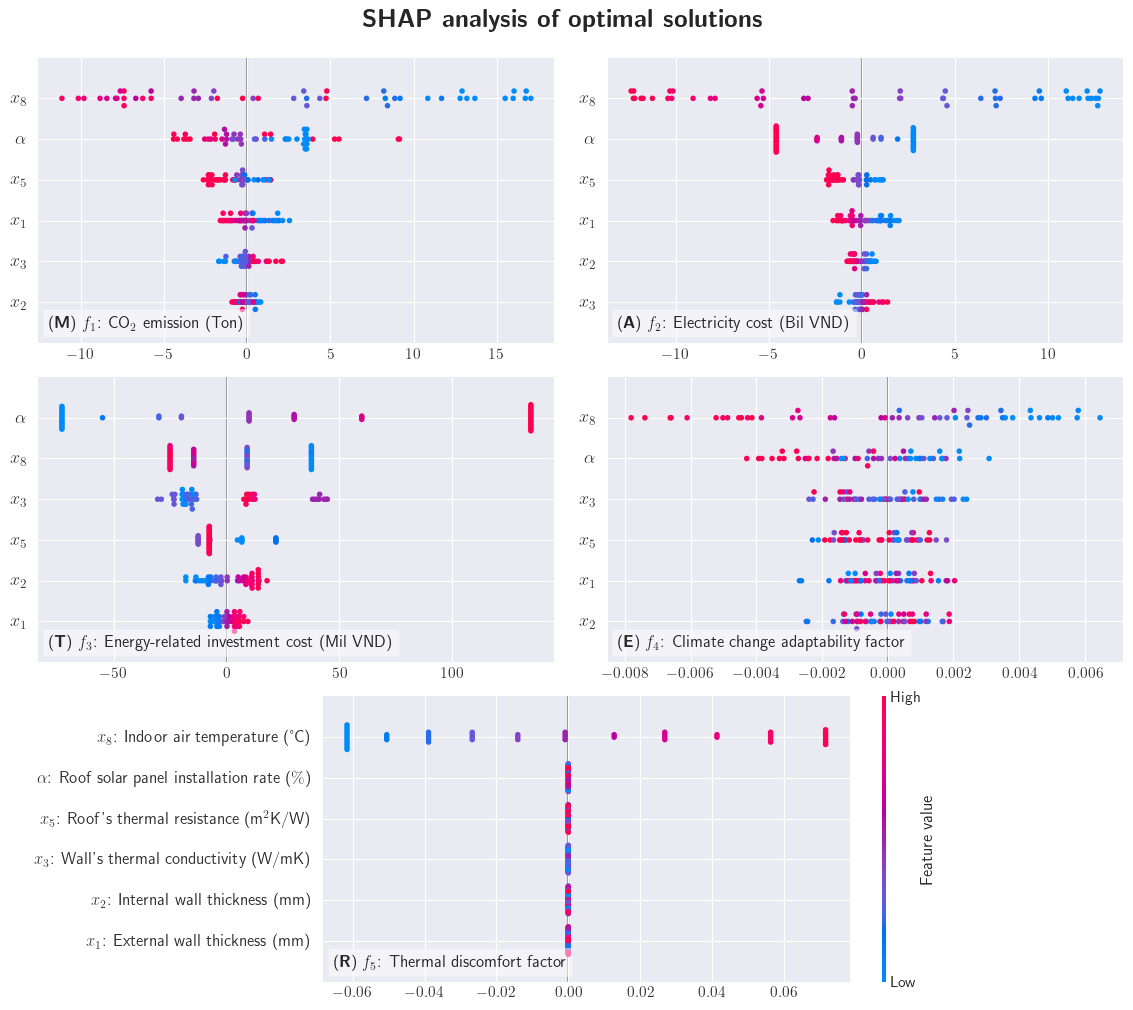

In [ ]:
variables_labels = ["$x_{1}$: External wall thickness (mm)", 
                    "$x_{2}$: Internal wall thickness (mm)", 
                    "$x_{3}$: Wall's thermal conductivity (W/mK)", 
                    "$x_{5}$: Roof's thermal resistance (m$^{2}$K/W)",
                    "$x_{8}$: Indoor air temperature (°C)",
                    "$\\alpha$: Roof solar panel installation rate ($\%$)"]

objective_functions = ["(\\textbf{M}) $f_{1}$: CO$_{2}$ emission (Ton)",
                       "(\\textbf{A}) $f_{2}$: Electricity cost (Bil VND)",
                       "(\\textbf{T}) $f_{3}$: Energy-related investment cost (Mil VND)",
                       "(\\textbf{E}) $f_{4}$: Climate change adaptability factor",
                       "(\\textbf{R}) $f_{5}$: Thermal discomfort factor"]

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['text.usetex'] = True

[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(14, 12))
fig.suptitle(r'\textbf{SHAP analysis of optimal solutions}', y=0.92, fontsize=18)
gs = gridspec.GridSpec(nrows+1, ncols*4, figure=fig)

for i in range(len(objective_functions)):
    col = objective_functions[i]
    if i != len(objective_functions) - 1:
        plt.subplot(gs[i // ncols, 4*(i % ncols) : 4*(i % ncols) + 4])
        shap.plots.beeswarm(shap_values[..., i], plot_size=None, color_bar=False, show=False)
        plt.xlabel('')
        plt.yticks(fontsize=13, va='center', position=(0.04, 0))
    else:
        plt.subplot(gs[2, 2:-1])
        shap.plots.beeswarm(shap_values[..., i], plot_size=None, color_bar=True, show=False)
        plt.xlabel('')
        plt.yticks(range(len(variables_labels)), [variables_labels[i] for i in [0, 1, 2, 3, 5, 4]], fontsize=12, va='center', position=(0.04, 0))

    plt.text(0.02, 0.04, rf'{col}', transform=plt.gca().transAxes, fontsize=12,
             ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
    # break

# plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.12, wspace=0.6)
plt.savefig(os.path.join(result_dir, 'SHAP_Analysis.png'), dpi=400)
plt.show()
